In [17]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import re
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
import openai

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try without goalies
#data = data[(data['Position'] != 'G')]
#data = data[(data['Position'] == 'C') | (data['Position'] == 'LW') | (data['Position'] == 'RW')]

# encode position
# TODO: we should keep the positions for when we do clustering
position = preprocessing.LabelEncoder()
position.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: position.transform([x])[0])

#team = preprocessing.LabelEncoder()
#team.fit(data['Team'].unique())
#data['Team'] = data['Team'].apply(lambda x: team.transform([x])[0])

height_scaler = preprocessing.MinMaxScaler()
data['Height'] = height_scaler.fit_transform(data['Height'].values.reshape(-1, 1))
weight_scaler = preprocessing.MinMaxScaler()
data['Weight'] = weight_scaler.fit_transform(data['Weight'].values.reshape(-1, 1))


data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,0,0.277778,0.278499,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,0,0.592593,0.292929,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,4,0.296296,0.011544,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,0,0.666667,0.343434,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,3,0.277778,0.170274,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [19]:
corpus, labels, draft_position, player_position, player_name, team, height, weight = [], [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]


# remove references to leagues, teams, and nationalities
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "wing", "saginaw", "kelowna", "frolunda",
                "slovakia"]


for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    scouting_report = row[report]
    scouting_report = scouting_report.lower()
    # remove player name from report
    names = row['Name'].lower().split(' ')
    for name in names:
      scouting_report = scouting_report.replace(name + "'s", '')
      scouting_report = scouting_report.replace(name, '')
    
    scouting_report = scouting_report.replace('\n', ' ')
    scouting_report = scouting_report.replace('\r', '')

    # remove hockey specific stop words
    # TODO: there is an issue where a hockey word includes punctuation, it does not get remov ed
    # for instance: "usntdp," will not get removed
    scouting_report = scouting_report.split()
    scouting_report = [word for word in scouting_report if (word.replace("'s", "").replace(",", "").replace(".", "") not in hockey_words)]
    # join back on spaces
    scouting_report = ' '.join(scouting_report)

    text = text + " " + scouting_report

  # append to dataset
  corpus.append(' '.join(text.split()[:1500]))
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  team.append(row['Team'])
  height.append(row['Height'])
  weight.append(row['Weight'])
# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 402
length of labels: 402
length of draft_position: 402
length of player_position: 402
corpus first 5: ["is a potential franchise-changing no. 1 prospect. his skill and shot are legit game-breaking attributes. his ability to beat defenders one-on-one is among the best i've ever seen by a 17-year-old, and the pace at which he displays that elite skill is going to allow him to execute those types of skilled plays in the nhl. is a highly imaginative puckhandler and a very creative passer. that, combined with the fact his wrist shot is a top-tier nhl weapon from anywhere in the offensive zone, makes him a projected nightmare for nhl coaches to stop on the power play. the only downside to his game is his frame, which has some scouts wondering if he gets pushed off to the in the nhl. he isn't a pushover though, as he plays hard and has a physical edge in his game. given his success as a junior his strong skating and his high compete level, i think whoever drafts him will ha

In [21]:
# attempting to vectorize using bert embeddings
from openai.embeddings_utils import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import os


embedding_model = "text-similarity-curie-001"
openai.api_key = ""
if os.path.exists("data/reports_with_embeddings.csv"):
    X = pd.read_csv("data/reports_with_embeddings.csv")
    X['embeddings'] = X.embeddings.apply(eval).apply(np.array)
    embeddings = np.vstack(X['embeddings'].values).astype(np.float64)
    X['embeddings'] = [np.array(x, dtype=np.float64) for x in embeddings]
else:
    X = pd.DataFrame(list(zip(team, player_name, height, weight, draft_position, player_position, corpus)), columns=['team', 'player_name', 'height', 'weight', 'draft_position', 'player_position', 'report'])
    #Encode all sentences
    X["embeddings"] = X.report.apply(lambda x: openai.embeddings_utils.get_embedding(x, engine=embedding_model))
    X.to_csv("data/reports_with_embeddings.csv", index=False)
    Y = labels



sentences = X['report'].values
players = X['player_name'].values
#embeddings = X_train["embeddings"].values
embeddings = np.vstack(X['embeddings'].values).astype(np.float64)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:10]:
    print("{} \t {} \t {:.4f}".format(players[i], players[j], cos_sim[i][j]))

Top-5 most similar pairs:
Tyson Jost 	 Brock Boeser 	 0.9326
Aleksi Heponiemi 	 Sam Steel 	 0.9300
Jacob Larsson 	 Jeremy Roy 	 0.9284
Leo Carlsson 	 David Edstrom 	 0.9274
Mikko Rantanen 	 Jake Virtanen 	 0.9265
Liam Ohgren 	 Oskar Olausson 	 0.9258
Axel Sandin Pellikka 	 Quinn Hughes 	 0.9256
Matthew Barzal 	 Josh Ho-Sang 	 0.9252
Kyle Connor 	 Nick Merkley 	 0.9250
Adrien Kempe 	 Ivan Barbashev 	 0.9250


In [22]:


#X_train['embeddings'] = [embedding.mean(dtype=np.float64) for embedding in X_train['embeddings'].values]
X['embeddings'].head(1)

0    [-0.007158181630074978, 0.001936763641424477, ...
Name: embeddings, dtype: object

Exploring Kmeans now for unsupervised learning

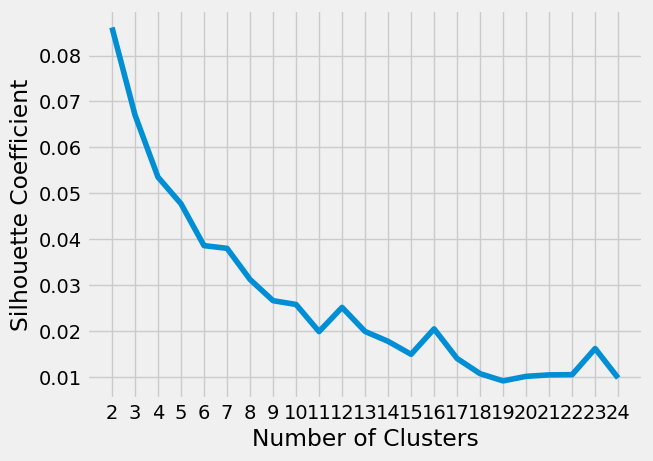

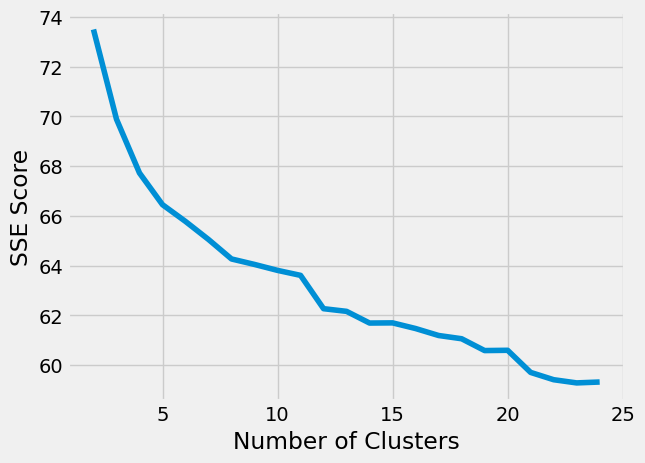

In [25]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []

  formated_data = data

  sse = {}
  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse[k] = kmeans.inertia_

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE Score")
  plt.show()

formated_data = np.vstack(X['embeddings'])
temp_data = []
for index, row in enumerate(formated_data):
  temp_data.append(np.concatenate((formated_data[index], [X['height'].values[index]])))
  #temp_data.append(np.concatenate((formated_data[index], [X['height'].values[index]], [X['weight'].values[index]])))
  #temp_data.append(np.concatenate(([X_train['height'].values[index]], [X_train['weight'].values[index]])))
  #temp_data.append(formated_data[index])
  #formated_data[index] = np.append(formated_data[index], X_train['weight'].values[index])
data = np.array(temp_data)
plot_silhouette_scores(data, 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [26]:
SELECTED_CLUSTERS = 4

In [27]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
labels = kmeans.fit_predict(data)

X['label'] = labels

In [28]:
# show the top words for each cluster that was created
def get_top_features_cluster(X_train):
    data = X_train[X_train['label'] == 0]
    for index, row in data.iterrows():
        print("")
        print("player name: {}", row['player_name'])
        print(row['report'])
        
    

get_top_features_cluster(X)


player name: {} Colby Barlow
is a well-rounded winger. he is a strong skater who can transport pucks through the neutral zone. he's a hard-working forward who has some physicality, can kill penalties, and is quite physically advanced for his age. offensively he has excellent stick skills and a great shot. he's a threat to score off the rush and from a standstill with his one-timer. playmaking isn't his selling point, but it's good enough, especially with how skilled he is at creating scoring opportunities for himself. he projects as a top six who can play on both special teams in the nhl. one of the more impressive 2005s in the in each of his two seasons, scored 35 goals in 66 combined regular-season and playoff games as a rookie in the was named captain of the attack for his draft year, and scored 49 goals in 63 combined games this season (both rare goal scoring for a player his age, and a rare honour for a player his age). plays a direct, intentional game built around great hands, a

In [29]:
import plotly.express as px

print(X.columns)
print(X.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['team', 'player_name', 'height', 'weight', 'draft_position',
       'player_position', 'report', 'embeddings', 'label'],
      dtype='object')
  team     player_name    height    weight  draft_position  player_position  \
0  NaN   Connor Bedard  0.277778  0.278499             NaN                0   
1  NaN   Adam Fantilli  0.592593  0.292929             NaN                0   
2  NaN  Matvei Michkov  0.296296  0.011544             NaN                4   
3  NaN    Leo Carlsson  0.666667  0.343434             NaN                0   
4  NaN     Zach Benson  0.277778  0.170274             NaN                3   

                                              report  \
0  is a potential franchise-changing no. 1 prospe...   
1  there's so much to love about nhl projection. ...   
2  is one of the very best first-year draft eligi...   
3  has elite skill, which when combined with his ...   
4  has a ton of creativity and offense in his gam...   

                                      

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



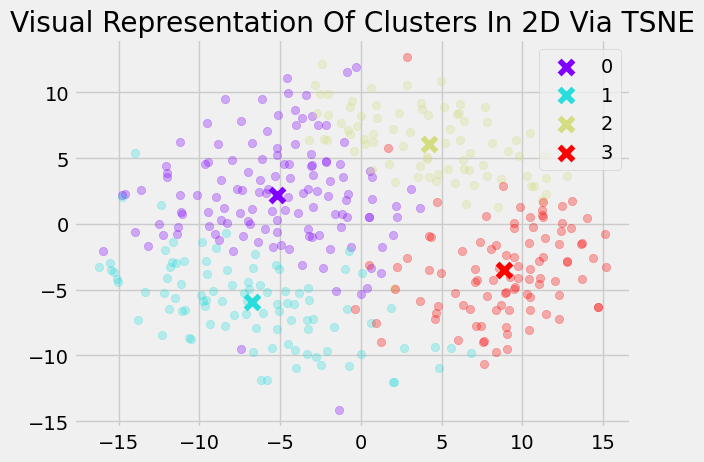

In [30]:
tsne = TSNE(n_components=2, learning_rate=200)
vis_dims2 = tsne.fit_transform(data)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X.label == category]
    ys = np.array(y)[X.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()

ModuleNotFoundError: No module named 'umap.umap_'

team  label
DET   1        6
      2        6
      3        2
      4        2
Name: label, dtype: int64


C:\Users\Ryan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



team
DET    AxesSubplot(0.08,0.07;0.87x0.81)
Name: label, dtype: object

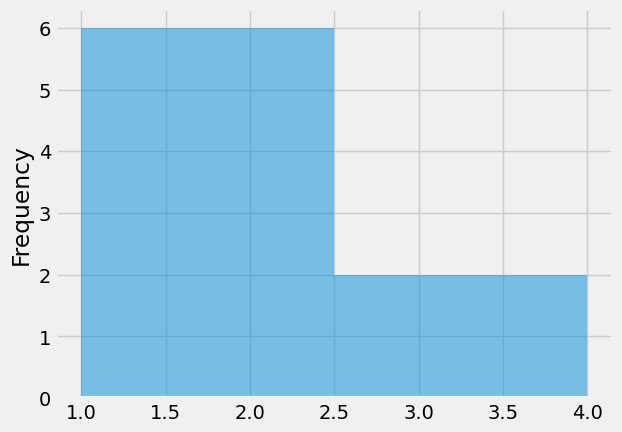

In [49]:

test_data = X.dropna()

test_data['label'] = test_data['label'] + 1
team_averags = test_data.groupby('team')['label'].mean()

rows = 4
cols = 8
figsize = (160, 90)
fig, axes = plt.subplots(rows, cols, sharex=True, figsize=(figsize[0], figsize[1]))
j = 0
row = 0
team_colors = {
    "MON": "red",
    "SEA": "aqua",
    "NJD": "firebrick",
    "ARI": "sienna",
    "CBJ": "cornflowerblue",
    "BUF": "darkblue",
    "NSH": "gold",
    "VAN": "teal",
    "CHI": "lightcoral",
    "PHI": "orange",
    "MIN": "darkgreen",
    "ANA": "darkorange",
    "WPG": "navy",
    "DET": "crimson",
    "TBL": "dodgerblue",
    "WSH": "slategray",
    "STL": "mediumblue",
    "PIT": "darkkhaki",
    "CAR": "red",
    "DAL": "forestgreen",
    "NYI": "blue",
    "SJS": "lightseagreen",
    "LAK": "dimgray",
    "BOS": "goldenrod",
    "CGY": "orangered",
    "NYR": "mediumblue",
    "COL": "maroon",
    "EDM": "cornflowerblue",
    "FLA": "yellow",
    "VGK": "darkgoldenrod",
    "OTT": "brown",
    "TML": "dodgerblue"
}

for i, team in enumerate(test_data.team.unique()):
    if j == 8:
        j = 0
        row = row + 1
    counts = test_data[test_data['team'] == team]['label'].value_counts()
    sorted_indexes = test_data[test_data['team'] == team]['label'].value_counts().index.tolist().sort()
    values = []
    for k in range(4):
        try:
            values.append(counts.loc[[k+1]].values[0])
        except:
            values.append(0)
    
    axes[row][j].bar([1,2,3,4], values, color=team_colors[team])
    axes[row][j].set_title(f"{team}\navg:{round(test_data[test_data['team'] == team]['label'].mean(), 1)},n={len(test_data[test_data['team'] == team])}", fontsize=140)
    axes[row][j].set_xlabel('Cluster')
    axes[row][j].set_ylabel('Count')

    j = j + 1
fig.tight_layout(pad=10.0)  
#plt.title("Top 40 Selection By Cluster For Each Team (2014-2022)")
plt.show()
